In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [27]:
df = pd.read_csv('source/FReDA2.csv')

In [28]:
def val_to_category(val):
    if -0.5 <= val < 0.5:
        return 0
    elif 0.5 <= val < 2:
        return 1
    elif 2 <= val < 3:
        return 2
    elif 3 <= val < 4:
        return 3
    elif 4 <= val < 5:
        return 4
    elif val >= 5:
        return 5
    elif -2 < val < -0.5:
        return -1
    elif -3 < val <= -2:
        return -2
    elif -4 < val <= -3:
        return -3
    elif -5 < val <= -4:
        return -4
    elif val <= -5:
        return -5


df['Anchor FreqCat'] = df['Anchor Frequency of Touch'].apply(val_to_category)
df['Anchor WishCat'] = df['Anchor Wish for Touch'].apply(val_to_category)
df['Partner FreqCat'] = df['Partner Frequency of Touch'].apply(val_to_category)
df['Partner WishCat'] = df['Partner Wish for Touch'].apply(val_to_category)
df['Couple FreqCat'] = df['Couple Frequency of Touch'].apply(val_to_category)
df['Couple WishCat'] = df['Couple Wish for Touch'].apply(val_to_category)
df['Couple DiffCat'] = df['Couple Difference of Touch'].apply(val_to_category)

In [29]:
predictors = [
    # 'Anchor Frequency of Touch',
    # 'Anchor Wish for Touch',
    'Anchor Age',
    'Anchor Work Status',
    'Anchor East',
    'Anchor Urbanization',
    'Anchor Extraversion',
    'Anchor Agreeableness',
    'Anchor Conscientiousness',
    'Anchor Openness',
    'Anchor Neuroticism',
    'Anchor Conservatism',
    'Anchor Religiosity',
    'Anchor Depressiveness',
    'Anchor Loneliness',
    'Anchor Self-esteem',
    'Anchor Life Satisfaction',
    'Anchor Health',
    'Anchor Communication Quality',
    'Anchor Relationship Satisfaction',
    'Anchor Conflict Management',

    # 'Partner Frequency of Touch',
    # 'Partner Wish for Touch',
    'Partner Age',
    'Partner Work Status',
    'Partner East',
    'Partner Urbanization',
    'Partner Extraversion',
    'Partner Agreeableness',
    'Partner Conscientiousness',
    'Partner Openness',
    'Partner Neuroticism',
    'Partner Conservatism',
    'Partner Religiosity',
    'Partner Depressiveness',
    'Partner Loneliness',
    'Partner Self-esteem',
    'Partner Life Satisfaction',
    'Partner Health',
    'Partner Communication Quality',
    'Partner Relationship Satisfaction',
    'Partner Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
    'Kid Age'
]

anchor_predictors = [
    # 'Anchor Difference of Touch',

    'Anchor Age',
    'Anchor Work Status',
    'Anchor East',
    'Anchor Urbanization',

    'Anchor Extraversion',
    'Anchor Agreeableness',
    'Anchor Conscientiousness',
    'Anchor Openness',
    'Anchor Neuroticism',
    'Anchor Conservatism',
    'Anchor Religiosity',

    'Anchor Depressiveness',
    'Anchor Loneliness',
    'Anchor Self-esteem',
    'Anchor Life Satisfaction',
    'Anchor Health',

    'Anchor Communication Quality',
    'Anchor Relationship Satisfaction',
    'Anchor Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
    'Kid Age'
]

partner_predictors = [
    # 'Partner Difference of Touch',

    'Partner Age',
    'Partner Work Status',
    'Partner East',
    'Partner Urbanization',

    'Partner Extraversion',
    'Partner Agreeableness',
    'Partner Conscientiousness',
    'Partner Openness',
    'Partner Neuroticism',
    'Partner Conservatism',
    'Partner Religiosity',

    'Partner Depressiveness',
    'Partner Loneliness',
    'Partner Self-esteem',
    'Partner Life Satisfaction',
    'Partner Health',
    'Partner Communication Quality',
    'Partner Relationship Satisfaction',
    'Partner Conflict Management',

    'Relationship Sex',
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',
    'Kid Age'
]

In [30]:
anchor_dependent = [
    'Anchor FreqCat',
    'Anchor WishCat',
    # 'Anchor Frequency of Touch',
    # 'Anchor Wish for Touch'
]
partner_dependent = [
    'Partner FreqCat',
    'Partner WishCat',
]
couple_dependent = [
    # 'Couple FreqCat',
    # 'Couple WishCat',
    'Couple DiffCat'
]

In [31]:
df['Group'].value_counts()

Group
Disagreement    3131
Agreement       1922
Concession      1746
Name: count, dtype: int64

In [32]:
df = df.dropna().reset_index(drop=True)

In [33]:
df['Group'].value_counts()

Group
Disagreement    2184
Agreement       1333
Concession      1254
Name: count, dtype: int64

In [34]:
df['SubGroup'].value_counts()

SubGroup
Disagreement                2184
Deprived Agreement          1227
High Frequency Agreement    1048
Low Frequency Agreement      279
Saturated Agreement           27
Non-Touch Agreement            6
Name: count, dtype: int64

In [35]:
group_agreement = df[df['Group'] == 'Agreement'].dropna().reset_index(drop=True)
group_disagreement = df[df['Group'] == 'Disagreement'].dropna().reset_index(drop=True)
group_concession = df[df['Group'] == 'Concession'].dropna().reset_index(drop=True)

In [36]:
x = df[predictors]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["Variable"] = x.columns

# https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/regression/how-to/fit-binary-logistic-model/interpret-the-results/all-statistics-and-graphs/coefficients-and-regression-equation/
# VIF 	Multicollinearity
# VIF = 1 	None
# 1 < VIF < 5 	Moderate
# VIF > 5 	High

print(vif.sort_values(by="VIF", ascending=False))

           VIF                           Variable
0   180.233108                         Anchor Age
19  159.900913                        Partner Age
18  100.538730         Anchor Conflict Management
37   98.221080        Partner Conflict Management
35   97.747020      Partner Communication Quality
16   92.283461       Anchor Communication Quality
17   57.708888   Anchor Relationship Satisfaction
36   56.721753  Partner Relationship Satisfaction
33   48.060325          Partner Life Satisfaction
13   45.884074                 Anchor Self-esteem
32   44.766335                Partner Self-esteem
14   44.085588           Anchor Life Satisfaction
5    37.238248               Anchor Agreeableness
24   36.294786              Partner Agreeableness
15   35.033230                      Anchor Health
6    32.433483           Anchor Conscientiousness
34   32.147127                     Partner Health
2    31.987931                        Anchor East
25   30.983180          Partner Conscientiousness


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

X = df[predictors]
y = df["Couple DiffCat"]

model = LinearRegression()
model.fit(X, y)  # X: your predictors, y: dependent variable

result = permutation_importance(model, X, y, n_repeats=30, random_state=42)
importances = result.importances_mean

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Cumulative'] = importance_df['Importance'].cumsum()
importance_df['Cumulative %'] = importance_df['Cumulative'] / importance_df['Importance'].sum()

top_predictors = importance_df[importance_df['Cumulative %'] <= 0.95]
print(top_predictors)

                              Feature  Importance  Cumulative  Cumulative %
36  Partner Relationship Satisfaction    0.034536    0.034536      0.153343
43                               Kids    0.029956    0.064493      0.286351
17   Anchor Relationship Satisfaction    0.027905    0.092397      0.410250
42                       Cohabitation    0.026235    0.118632      0.526735
16       Anchor Communication Quality    0.021761    0.140393      0.623356
35      Partner Communication Quality    0.012746    0.153139      0.679948
39                Relationship Length    0.010914    0.164053      0.728407
12                  Anchor Loneliness    0.010829    0.174882      0.776486
31                 Partner Loneliness    0.006830    0.181712      0.806811
19                        Partner Age    0.006696    0.188408      0.836544
20                Partner Work Status    0.005498    0.193906      0.860957
6            Anchor Conscientiousness    0.002881    0.196788      0.873750
33          

In [38]:
# X = df[predictors]
# y = df["Couple WishCat"]
#
# model = LinearRegression()
# model.fit(X, y)  # X: your predictors, y: dependent variable
#
# result = permutation_importance(model, X, y, n_repeats=30, random_state=42)
# importances = result.importances_mean
#
# feature_names = X.columns
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# })
# importance_df = importance_df.sort_values(by='Importance', ascending=False)
# importance_df['Cumulative'] = importance_df['Importance'].cumsum()
# importance_df['Cumulative %'] = importance_df['Cumulative'] / importance_df['Importance'].sum()
#
# top_predictors = importance_df[importance_df['Cumulative %'] <= 0.95]
# print(top_predictors)

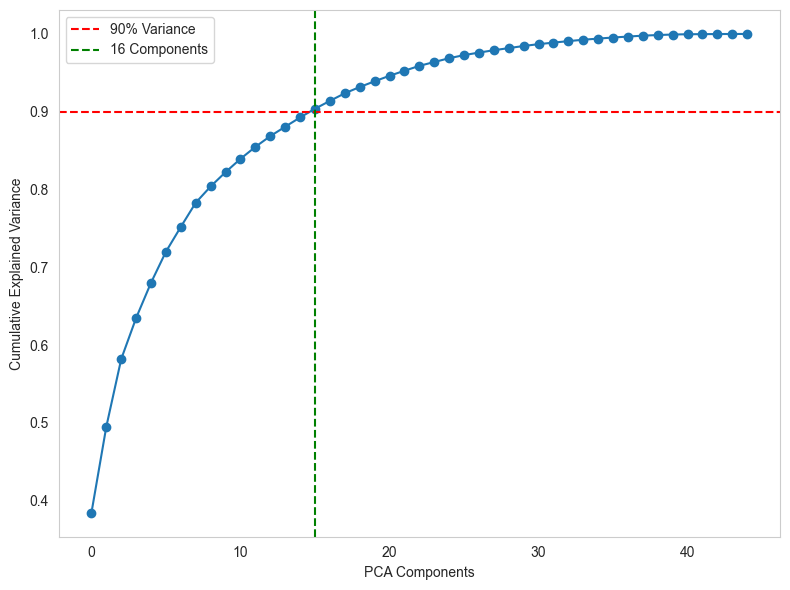

In [39]:
target_predictors = predictors
target_variance = 0.9

x = df[target_predictors]
# X_scaled = StandardScaler().fit_transform(X)
# Specific statistical transformation involving subtraction of the average and subsequent division by
# the standard deviation.

pca = PCA()
x_pca = pca.fit_transform(x)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to reach target % variance
n_components_90 = np.argmax(cumulative_variance >= target_variance) + 1  # +1 because index starts at 0

# Plot
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance * 100)}% Variance')
plt.axvline(x=n_components_90 - 1, color='g', linestyle='--',
            label=f'{n_components_90} Components')  # subtract 1 for correct index on plot
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Keep only the first `n_components_90` components
x_pca_90 = x_pca[:, :n_components_90]
pca_df = pd.DataFrame(x_pca_90, columns=[f'PC{i + 1}' for i in range(n_components_90)])

# Slice the loadings too
loadings = pd.DataFrame(pca.components_.T[:, :n_components_90],
                        columns=[f'PC{i + 1}' for i in range(n_components_90)],
                        index=target_predictors)

In [41]:
print(x.columns)

Index(['Anchor Age', 'Anchor Work Status', 'Anchor East',
       'Anchor Urbanization', 'Anchor Extraversion', 'Anchor Agreeableness',
       'Anchor Conscientiousness', 'Anchor Openness', 'Anchor Neuroticism',
       'Anchor Conservatism', 'Anchor Religiosity', 'Anchor Depressiveness',
       'Anchor Loneliness', 'Anchor Self-esteem', 'Anchor Life Satisfaction',
       'Anchor Health', 'Anchor Communication Quality',
       'Anchor Relationship Satisfaction', 'Anchor Conflict Management',
       'Partner Age', 'Partner Work Status', 'Partner East',
       'Partner Urbanization', 'Partner Extraversion', 'Partner Agreeableness',
       'Partner Conscientiousness', 'Partner Openness', 'Partner Neuroticism',
       'Partner Conservatism', 'Partner Religiosity', 'Partner Depressiveness',
       'Partner Loneliness', 'Partner Self-esteem',
       'Partner Life Satisfaction', 'Partner Health',
       'Partner Communication Quality', 'Partner Relationship Satisfaction',
       'Partner Confli

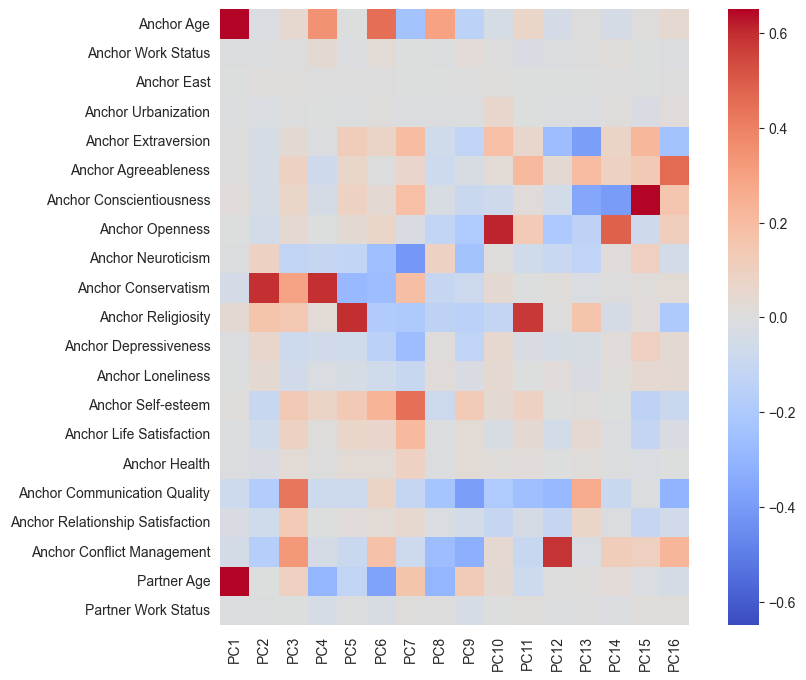

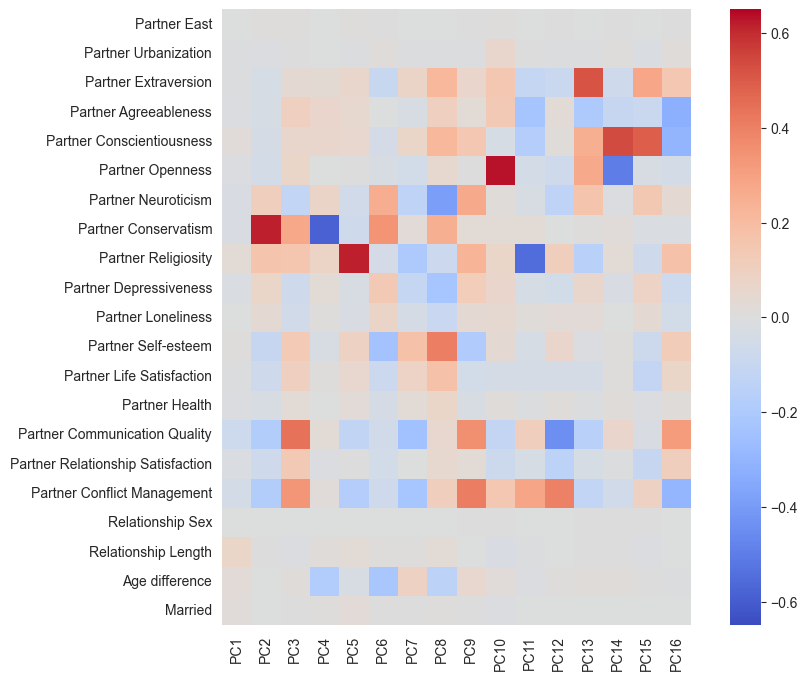

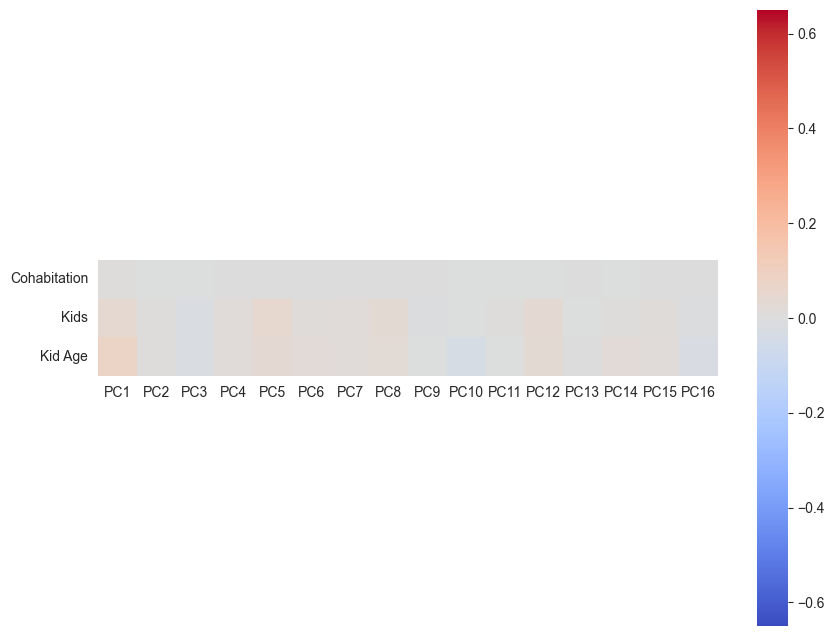

In [42]:
# loadings_df = pd.DataFrame(pca.components_.T, index=x.columns, columns=[f'PC{i + 1}' for i in range(pca.n_components_)])
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[0:21, :18],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings1.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[21:42, :18],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings2.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.iloc[42:47, :18],
            cmap="coolwarm",
            center=0,
            vmax=0.65,
            vmin=-0.65,
            square=True,
            )
plt.savefig('output/img_bg/loadings3.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.title("PCA Loadings")
plt.show()

In [43]:
loadings['PC1'].sort_values(key=abs, ascending=False).head(10)

Partner Age                      0.738112
Anchor Age                       0.647378
Kid Age                          0.076184
Anchor Communication Quality    -0.074237
Partner Communication Quality   -0.073451
Relationship Length              0.066441
Partner Conflict Management     -0.047341
Anchor Conflict Management      -0.045920
Kids                             0.042786
Anchor Conservatism             -0.042541
Name: PC1, dtype: float64

Optimization terminated successfully.
         Current function value: 0.807200
         Iterations: 49
         Function evaluations: 53
         Gradient evaluations: 53


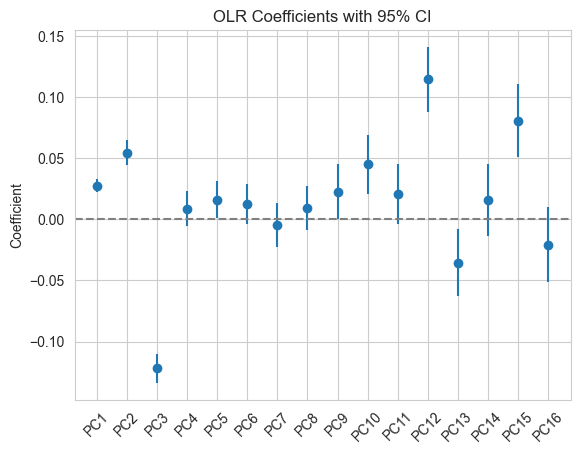

                             OrderedModel Results                             
Dep. Variable:         Couple DiffCat   Log-Likelihood:                -3851.1
Model:                   OrderedModel   AIC:                             7750.
Method:            Maximum Likelihood   BIC:                             7906.
Date:                Tue, 09 Sep 2025                                         
Time:                        13:46:23                                         
No. Observations:                4771                                         
Df Residuals:                    4747                                         
Df Model:                          16                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            0.0274      0.003      9.977      0.000       0.022       0.033
PC2            0.0546      0.005     10.704      0.0

In [44]:
x = pca_df

for d in couple_dependent:
    y = df[d]
    mod = OrderedModel(y, x, distr='logit')
    res = mod.fit(method='bfgs')

    coefs = res.params
    coefs = coefs.iloc[:n_components_90]
    conf = res.conf_int()
    conf = conf.iloc[:n_components_90, :]
    plt.errorbar(coefs.index, coefs.values,
                 yerr=[coefs.values - conf[0], conf[1] - coefs.values],
                 fmt='o')
    plt.axhline(0, color='grey', linestyle='--')
    plt.xticks(rotation=45)
    plt.ylabel('Coefficient')
    plt.title('OLR Coefficients with 95% CI')
    plt.show()
    print(res.summary())

In [45]:
# x = df[anchor_predictors]
# y = df["Couple FreqCat"]
# mod = OrderedModel(y, x, distr='logit')
# res = mod.fit(method='bfgs')
#
# coefs = res.params
# coefs = coefs.iloc[2:26]
# conf = res.conf_int()
# conf = conf.iloc[2:26, :]
# plt.errorbar(coefs.index, coefs.values,
#              yerr=[coefs.values - conf[0], conf[1] - coefs.values],
#              fmt='o')
# plt.axhline(0, color='grey', linestyle='--')
# plt.xticks(rotation=90)
# plt.ylabel('Coefficient')
# plt.title('OLR Coefficients with 95% CI')
# plt.show()
# print(res.summary())


In [46]:
# coefs = res.params
# coefs = coefs.iloc[:16]
# conf = res.conf_int()
# conf = conf.iloc[:16, :]
# plt.errorbar(coefs.index, coefs.values,
#              yerr=[coefs.values - conf[0], conf[1] - coefs.values],
#              fmt='o')
# plt.axhline(0, color='grey', linestyle='--')
# plt.xticks(rotation=45)
# plt.ylabel('Coefficient')
# plt.title('OLR Coefficients with 95% CI')
# plt.show()

In [47]:
# Check for robutness, p values are similar although coeff may vary
# x = pca_df
# x = sm.add_constant(x)
#
# test = [
#     'Couple Frequency of Touch',
#     'Couple Wish for Touch',
# ]
#
# for d in test:
#     y = df[d]
#     model_freq = sm.OLS(y, x, missing='drop').fit()
#     print(model_freq.summary())

In [48]:
# test_group = df[df['SubGroup'] == 'High Frequency Agreement']
# test_group = df[df['SubGroup'] == 'Low Frequency Agreement']
# test_group = df[df['Group'] == 'Concession']
# test_group = df[df['Group'] == 'Agreement']
# test_group = df[df['Group'] == 'Disagreement']

# print(test_group['Id'].size)